In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import textwrap 

# Some tools for writing, reading and joining LOWDIN potentials

In [29]:
def write_potential_to_lowdin_format(potentialName,species,angularMomentum,exponents,coefficients,centers):
    
    outFile = open(potentialName, "w")
    
    outFile.write("O-"+species+"\n")
    outFile.write("#\n")
    outFile.write("%i\n" % (len(exponents)))
    
    for i in range(0,len(exponents)) :
        outFile.write( str(i+1) + " "+ str(int(angularMomentum[i]))+"\n" )
        outFile.write( "%.8f %.8e\n" % (exponents[i], coefficients[i]) )
        
        aux = str(centers[i][0])+" "+str(centers[i][1])+" "+str(centers[i][2])
    
        outFile.write( aux + "\n")

    outFile.close()

    
def read_lowdin_potential(potentialFile):
    
    exponents = []
    coefficients = []
    angular_momentum = []
    centers = []
    
    
    potential = open(potentialFile, 'r')
    lines_pot = potential.readlines()
    num_gauss_pot = int(lines_pot[2])
    
    species_line = lines_pot[0].strip()
    species = str(species_line[2])+str(species_line[3])
    
    for i in range(3, len(lines_pot),3):
        angular_momentum.append(int(lines_pot[i].split()[1]))
    
    for i in range(4,len(lines_pot),3):
        exponents.append(float(lines_pot[i].split()[0]))
        coefficients.append(float(lines_pot[i].split()[1]))
    
    for i in range(5, len(lines_pot),3):
        centers.append([lines_pot[i].split()[0],lines_pot[i].split()[1],lines_pot[i].split()[2]])
    
    return species, num_gauss_pot, angular_momentum, exponents, coefficients, centers     
    

def join_lowdin_potentials(first_potential, second_potential, resulting_potential):
    
    fp = read_lowdin_potential(first_potential)
    sp = read_lowdin_potential(second_potential)
    
    species = fp[0]
    resulting_gaussians = fp[1] + sp[1]
    angular_momentum = [*fp[2],*sp[2]]
    exponents = [*fp[3],*sp[3]]
    coefficients = [*fp[4],*sp[4]]
    centers = [*fp[5],*sp[5]]
    
    write_potential_to_lowdin_format(resulting_potential,species,angular_momentum,exponents,coefficients,centers)
    

# A function for constructing the gaussian sums used to fit

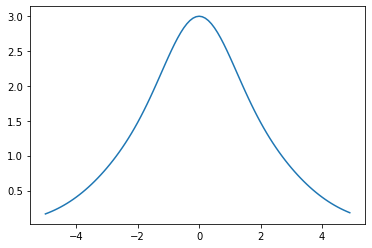

In [81]:
def create_python_function(name, body, parameters):
    
    exec(f"def {name}({parameters}):\n   {body}")
    
    return locals()[name]


def create_parameters(n):
    
    variable = "r"
    coefficients = []
    exponents = []
    
    
    for i in range(0,n):
        coefficients.append("a_"+str(i))
        exponents.append("b_"+str(i))
   
    return coefficients,exponents


def create_gaussians(name,coefficients,exponents,center):
    
    total_parameters_list = [*coefficients, *exponents]
    total_parameter_length = len(total_parameters_list)

    fitting_function = ""
    parameters = "r, "
    
    for i in range(0,len(coefficients)):
        if( i != len(coefficients)-1):
            fitting_function += f"{coefficients[i]}*np.exp(-{exponents[i]}*(r-{center})**2) + "
        else:
            fitting_function += f"{coefficients[i]}*np.exp(-{exponents[i]}*(r-{center})**2)"
    
    for i in range(0, total_parameter_length):
        if(i != total_parameter_length-1):
            parameters += f"{total_parameters_list[i]}, "
        else:
            parameters += f"{total_parameters_list[i]}"
    
    
    
    function_body = textwrap.dedent(f'''\
        return {fitting_function}
    ''')
    
    return create_function(name, function_body, parameters) 



### A little example of the use of this functions
"""
var = create_parameters(2)
    
A = create_gaussians("patito",var[0],var[1],0)
plt.figure()
plt.plot(np.arange(-5,5,0.1), A(np.arange(-5,5,0.1),2,1,0.1,0.5))
plt.show()
"""

    





In [3]:
datapath="/home/pmorenor/Desktop/PositronWork/H-/H-_normal/dataHminus2.dat"


def gaussians2(r,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,b_0,b_1,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9):
	return a_0*np.exp(-b_0*(r)**2)+a_1*np.exp(-b_1*(r)**2)+a_2*np.exp(-b_2*(r)**2)+a_3*np.exp(-b_3*(r)**2)+a_4*np.exp(-b_4*(r)**2)+a_5*np.exp(-b_5*(r)**2)+a_6*np.exp(-b_6*(r)**2)+a_7*np.exp(-b_7*(r)**2)+a_8*np.exp(-b_8*(r)**2)+a_9*np.exp(-b_9*(r)**2)

def gaussians3(r,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,b_0,b_1,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9):
	return a_0*np.exp(-b_0*(r-10)**2)+a_1*np.exp(-b_1*(r-10)**2)+a_2*np.exp(-b_2*(r-10)**2)+a_3*np.exp(-b_3*(r-10)**2)+a_4*np.exp(-b_4*(r-10)**2)+a_5*np.exp(-b_5*(r-10)**2)+a_6*np.exp(-b_6*(r-10)**2)+a_7*np.exp(-b_7*(r-10)**2)+a_8*np.exp(-b_8*(r-10)**2)+a_9*np.exp(-b_9*(r-10)**2)



Data = pd.read_csv(datapath, delim_whitespace=True, engine="python", header=None)


r = Data[0].astype(float)
r_Bohr = pd.Series([i*1.8897259886 for i in r])
V_ee = Data[2].astype(float)
V_Total = Data[3].astype(float)

In [22]:
popt_total, pcov_total = curve_fit(gaussians2, xdata=r_Bohr, ydata= V_Total, maxfev=50000)

L = [0 for i in range(0,len(popt_total))]

coefficients= np.split(popt_total,2)[0]
exponents= np.split(popt_total,2)[1]

centers1 = [[0.0,0.0,0.0] for i in range(0,len(popt_total))]
centers2 = [[10.0,0.0,0.0] for i in range(0,len(popt_total))]

write_potential_to_lowdin_format("FCENTER","E+",L,exponents,coefficients,centers1)
write_potential_to_lowdin_format("SCENTER","E+",L,exponents,coefficients,centers2)


/home/pmorenor/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
join_potentials("FCENTER","SCENTER","NTOTPOT","E+")
join_lowdin_potentials("FCENTER","SCENTER","SNTOTPOT")

In [20]:
HESPEEBOHR = read_potential("HEEBOHR")

In [21]:
print(HESPEEBOHR[0])

E+
